In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress, product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from scipy import optimize
from scipy.optimize import curve_fit
import warnings
from scipy.optimize import OptimizeWarning
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.decomposition import PCA

In [2]:
# Reading data
states = pd.read_csv("5.16states.csv")
abridged_couties = pd.read_csv("county_data_abridged.csv")
time_series_covid19_confirmed_US = pd.read_csv("time_series_covid19_confirmed_US.csv")
time_series_covid19_deaths_US = pd.read_csv("time_series_covid19_deaths_US.csv")

In [3]:
# create a copy of df and return a new df with fill mean
def fillmean(df):
    new_df = df.copy()
    for i in new_df.columns:
        column = new_df[i]
        if isinstance(column[0], int) or isinstance(column[0], float):
            new_df[i] = new_df[i].fillna(np.mean(column))
    return new_df

In [4]:
# return a new data Frame which sum all the column
def sum_all_column(df):
    index = 0
    for i in df.columns:
        if i == "1/22/20":
            break
        index += 1
    temp = df.copy().iloc[:,index:]
    analysis = pd.DataFrame()
    for i in temp.columns:
        analysis[i] = [np.sum(temp[i])]
    return analysis

In [5]:
def normalize(data):
    state = data['States']
    df = data.copy().iloc[:,1:]
    df = (df-df.mean()) / df.std()
    df.insert (0, "States", state)
    return df

In [6]:
# cleaning for states
states = states.drop(columns=['Country_Region','Lat','Long_','Last_Update','FIPS','UID','ISO3'])
states.drop(index=[9,13], inplace = True)
states = states.rename(columns={'Province_State':"States"})

# convert to 100%
states['Incident_Rate'] = states['Incident_Rate'] / 100000
states['Testing_Rate'] = states['Testing_Rate'] / 100000

states = fillmean(states)

In [7]:
# Clean data for time_series_covid19_confirmed_US

#select all the feature column only
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.iloc[:,5:]
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.rename(columns={'Province_State':"States"})
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.rename(columns={'Admin2':"County"})
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.drop(columns = {'Lat', 'Long_', 'Combined_Key', 'Country_Region'})
# replace the Nan County to States name
time_series_covid19_confirmed_US.loc[time_series_covid19_confirmed_US['County'].isna(), 'County'] = time_series_covid19_confirmed_US[time_series_covid19_confirmed_US['County'].isna()]['States']

# drop two ship
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.drop(index=[3200, 3252])

In [8]:
# Clean data for time_series_covid19_deaths_US

#select all the feature column only
time_series_covid19_deaths_US = time_series_covid19_deaths_US.iloc[:,5:]
time_series_covid19_deaths_US = time_series_covid19_deaths_US.rename(columns={'Province_State':"States"})
time_series_covid19_deaths_US = time_series_covid19_deaths_US.rename(columns={'Admin2':"County"})
time_series_covid19_deaths_US = time_series_covid19_deaths_US.drop(columns = {'Lat', 'Long_', 'Combined_Key', 'Country_Region'})
time_series_covid19_deaths_US.loc[time_series_covid19_deaths_US['County'].isna(), 'County'] = time_series_covid19_deaths_US[time_series_covid19_deaths_US['County'].isna()]['States']

# replace the Nan County to States name
time_series_covid19_confirmed_US.loc[time_series_covid19_confirmed_US['County'].isna(), 'County'] = time_series_covid19_confirmed_US[time_series_covid19_confirmed_US['County'].isna()]['States']

# drop two ship
time_series_covid19_deaths_US = time_series_covid19_deaths_US.drop(index=[3200, 3252])

In [9]:
# data cleaning for feature of spread

# create a map for 50 state
temp_map = {'Alabama' : 'AL','Alaska' : 'AK','Arizona' : 'AZ','Arkansas' : 'AR','California' : 'CA','Colorado' : 'CO','Connecticut' : 'CT',
'Delaware' : 'DE','Florida' : 'FL','Georgia' : 'GA','Hawaii' : 'HI','Idaho' : 'ID','Illinois' : 'IL','Indiana' : 'IN','Iowa' : 'IA',
'Kansas' : 'KS','Kentucky' : 'KY','Louisiana' : 'LA','Maine' : 'ME','Maryland' : 'MD','Massachusetts' : 'MA','Michigan' : 'MI',
'Minnesota' : 'MN','Mississippi' : 'MS','Missouri' : 'MO','Montana' : 'MT','Nebraska' : 'NE','Nevada' : 'NV','New Hampshire' : 'NH','New Jersey' : 'NJ',
'New Mexico' : 'NM','New York' : 'NY','North Carolina' : 'NC','North Dakota' : 'ND','Ohio' : 'OH','Oklahoma' : 'OK','Oregon' : 'OR',
'Pennsylvania' : 'PA','Rhode Island' : 'RI','South Carolina' : 'SC','South Dakota' : 'SD','Tennessee' : 'TN','Texas' : 'TX',
'Utah' : 'UT','Vermont' : 'VT','Virginia' : 'VA','Washington' : 'WA','West Virginia' : 'WV','Wyoming' : 'WY','Wisconsin' : 'WI',
'District of Columbia' : 'DC','American Samoa' : 'AS','Puerto Rico' : 'PR','Virgin Islands' : 'VI'}

state_map = dict()
for key, value in temp_map.items():
    state_map[value] = key

# drop MD GU in state
abridged_couties.drop(index=[3147,3148,3149,3150,3151,3152], inplace = True)

# replace the state column to full name
names = abridged_couties['StateName']
fullname = []
for name in names:
    fullname.append(state_map[name])
    
abridged_couties['State'] = fullname
abridged_couties = abridged_couties.rename(columns={'State':"States"})
abridged_couties = abridged_couties.iloc[:-2,:]
abridged_couties = abridged_couties.drop(abridged_couties.loc[:, 'countyFIPS':'StateName'].columns, axis = 1)
abridged_couties = abridged_couties.drop(abridged_couties.loc[:, 'lat':'Rural-UrbanContinuumCode2013'].columns, axis = 1)
abridged_couties.drop(columns=['CensusPopulation2010'], inplace = True)
abridged_couties = abridged_couties.drop(abridged_couties.loc[:, 'PopMale<52010':'mortality2015-17Estimated'].columns, axis = 1)

def one_hot_encoding_for_time(df):
    new_df = df.copy()
    
    for row in df.loc[:, 'stay at home':'foreign travel ban'].columns:
        min_day = min(new_df[row])
        new_df[row] = new_df[row] - min_day
        new_df[row] = new_df[row].fillna(99999)
    return new_df

abridged_couties['HeartDiseaseMortality'] = abridged_couties['HeartDiseaseMortality'] / 10000
abridged_couties['RespMortalityRate2014'] = abridged_couties['RespMortalityRate2014'] / 10000

abridged_couties = one_hot_encoding_for_time(abridged_couties)
abridged_couties = fillmean(abridged_couties)

In [10]:
# merge state and abridged_couties
state = abridged_couties['States']
do_mean = ['FracMale2017',
 'PopulationDensityperSqMile2010',
 'MedianAge2010',
 '3-YrDiabetes2015-17',
 'DiabetesPercentage',
 'HeartDiseaseMortality',
 'StrokeMortality',
 'Smokers_Percentage',
 'RespMortalityRate2014',
 'dem_to_rep_ratio',
 'stay at home',
 '>50 gatherings',
 '>500 gatherings',
 'public schools',
 'restaurant dine-in',
 'entertainment/gym',
 'federal guidelines',
 'foreign travel ban',
 'SVIPercentile' ]

do_sum = [i for i in abridged_couties.columns if i not in do_mean]

# select the state group by mean
mean_df = abridged_couties[do_mean].copy()
mean_df.insert(0, "States", state)

# select the state group by sum
sum_df = abridged_couties[do_sum].copy()

mean_df = mean_df.groupby("States", as_index = False).agg("mean")
sum_df = sum_df.groupby("States", as_index = False).agg("sum")
features_in_states = mean_df.merge(sum_df, on="States")

In [11]:
# A function to fitting the curve in the data set
def func(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

# the lose function
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

Number of curves can't fit by function : 0
They are : []


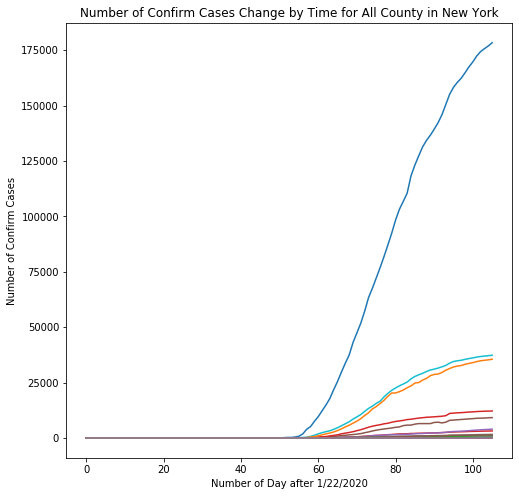

In [12]:
# create a graph for fitting county in New York

# select all county
county = time_series_covid19_confirmed_US.copy()
county = county[county["States"] == "New York"]
county = county.reset_index(drop = True)
county = county.drop(columns="States")
county = county.T
county.iloc[:,0].index
county = county.iloc[:,:58]
county.columns = county.iloc[0]
county = county.iloc[1:,]

# plot the graph
xdata = np.arange(0, county.shape[0])

plt.figure(figsize=(8,8))
cant_fit_state = []

#catch the expection for the graph can't fit by func
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    for i in range(county.shape[1]):
        ydata = county.iloc[:,i].values
        try:
            plt.plot(xdata, ydata)
            popt, pcov = curve_fit(func, xdata, ydata)
        except (RuntimeError, OptimizeWarning):
            cant_fit_state += [county_10000.columns[i]]
            pass
        
plt.xlabel("Number of Day after 1/22/2020")
plt.ylabel("Number of Confirm Cases")
plt.title("Number of Confirm Cases Change by Time for All County in New York")
print("Number of curves can't fit by function :",len(cant_fit_state))
print("They are :", cant_fit_state)
plt.show()

Number of curves can't fit by function : 0
They are : []
The mean rmse us : 484.06359038306636


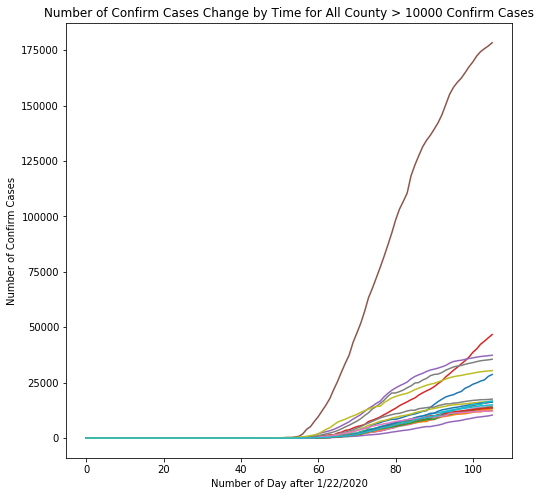

In [13]:
# create a graph for fitting county which have confirm > 10000 on 5/6/20

# select all county > 10000
county_10000 = time_series_covid19_confirmed_US.copy()
county_10000 = county_10000[county_10000['5/6/20'] > 10000]
county_10000 = county_10000.reset_index(drop = True)
county_10000 = county_10000.drop(columns="States")
county_10000 = county_10000.T
county_10000.columns = county_10000.iloc[0]
county_10000 = county_10000.iloc[1:,]

# plot the graph
xdata = np.arange(0, county_10000.shape[0])

plt.figure(figsize=(8,8))
cant_fit_state = []
error = []

# catch the expection for the graph can't fit by func
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    for i in range(county_10000.shape[1]):
        data = {'Date': county_10000.iloc[i,:].index, 'Confirmed': county_10000.iloc[i,:].values}
        result = pd.DataFrame(data=data)

        ydata = county_10000.iloc[:,i].values
        try:
            plt.plot(xdata, ydata)
            popt, pcov = curve_fit(func, xdata, ydata)
            y_hat = np.array([func(x, *popt) for x in xdata])
            error += [rmse(y_hat, ydata)]
            
        except (RuntimeError, OptimizeWarning):
            cant_fit_state += [county_10000.columns[i]]
            pass
plt.xlabel("Number of Day after 1/22/2020")
plt.ylabel("Number of Confirm Cases")
plt.title("Number of Confirm Cases Change by Time for All County > 10000 Confirm Cases")
print("Number of curves can't fit by function :",len(cant_fit_state))
print("They are :", cant_fit_state)
print("The mean rmse us :", np.mean(error))
plt.show()

Number of curves can't fit by function : 2
They are : ['Minnesota', 'West Virginia']
The mean rmse us : 400.85940649683187


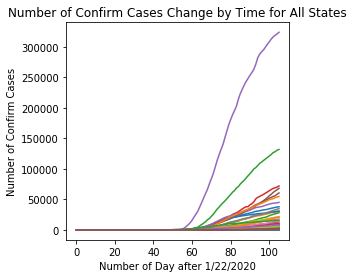

In [14]:
# create a graph for fitting all states
all_states = time_series_covid19_confirmed_US.groupby("States").agg("sum")

# plot the graph
xdata = np.arange(0, all_states.shape[0])

plt.figure(figsize=(4,4))
coefficient = dict()
cant_fit_state = []
error = []

# catch the expection for the graph can't fit by func
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)
    for i in range(all_states.shape[0]):
        data = {'Date': all_states.iloc[i,:].index, 'Confirmed': all_states.iloc[i,:].values}
        data_df = pd.DataFrame(data=data)

        xdata = np.arange(0, data_df.shape[0])
        ydata = data_df['Confirmed'].values
        try:
            plt.plot(xdata, ydata)
            popt, pcov = curve_fit(func, xdata, ydata)
            y_hat = np.array([func(x, *popt) for x in xdata])
            error += [rmse(y_hat, ydata)]
            coefficient[all_states.index[i]] = popt
        except (RuntimeError, OptimizeWarning):
            cant_fit_state += [all_states.index[i]]
            pass

plt.xlabel("Number of Day after 1/22/2020")
plt.ylabel("Number of Confirm Cases")
plt.title("Number of Confirm Cases Change by Time for All States")
print("Number of curves can't fit by function :",len(cant_fit_state))
print("They are :", cant_fit_state)
print("The mean rmse us :", np.mean(error))
plt.show()

In [15]:
# convert the coefficient data frame
coef_df = pd.DataFrame(data = coefficient).T
coef_df.insert(0, "States", coef_df.index)
coef_df = coef_df.reset_index(drop=True)
coef_df = coef_df.rename(columns={0:'a', 1:'b',2:'c'})

# merge the abridged table with coefficient table
abridged_analysis = normalize(abridged_couties)
abridged_analysis = abridged_analysis.merge(coef_df, on="States")
abridged_analysis = abridged_analysis.drop(columns=["States"])

Text(0.5, 1, 'Correlation between Features and Features')

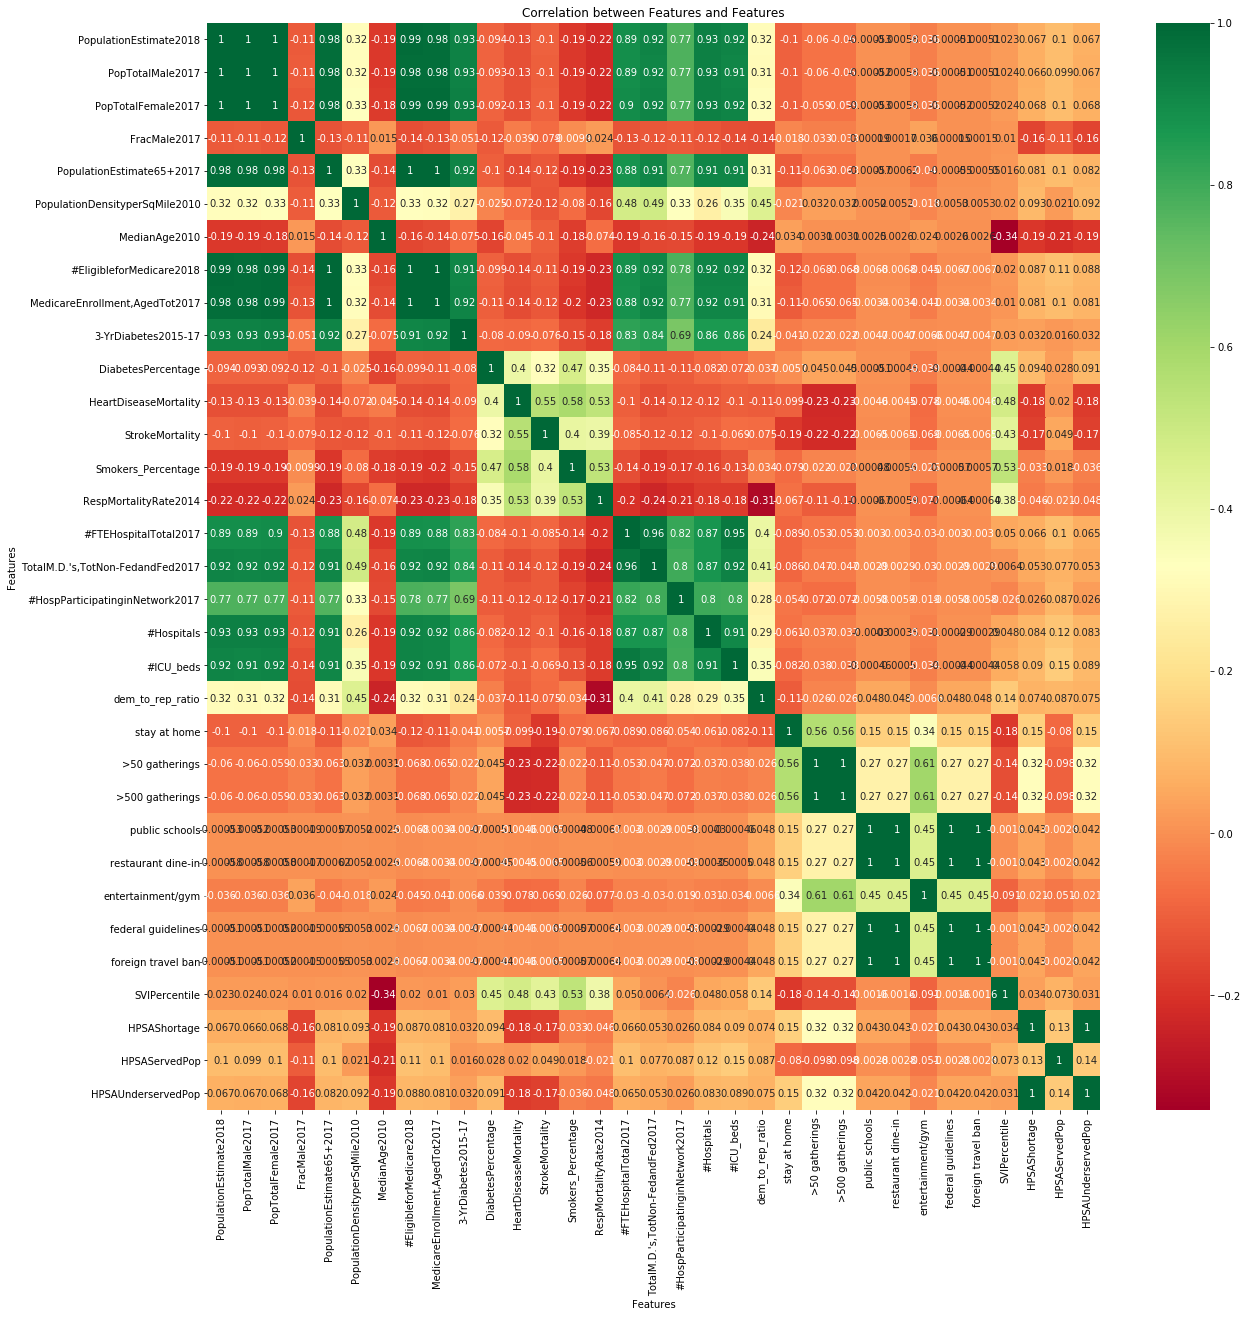

In [16]:
data = abridged_analysis.drop(columns=['a','b','c'])
most_features = data.corr().index
plt.figure(figsize=(20,20))
sns.heatmap(data[most_features].corr(),annot=True,cmap="RdYlGn")
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Correlation between Features and Features")

In [17]:
# select the feature by eyes
drop_feature = ['PopTotalMale2017', 'PopTotalFemale2017', 'PopulationEstimate65+2017', 'MedicareEnrollment,AgedTot2017',
                'StrokeMortality', "TotalM.D.'s,TotNon-FedandFed2017", '#ICU_beds', 'public schools', 'foreign travel ban',
                'HPSAUnderservedPop', '>50 gatherings', 'restaurant dine-in']
select_feature = [feature for feature in data.columns if feature not in drop_feature]
select_df = data[select_feature]
select_df_full = select_df.join(abridged_analysis[['a','b','c']])

full_table = features_in_states.merge(states[["States","Confirmed"]], on="States").drop(columns="States")
full_table = full_table[select_feature + ["Confirmed"]]

In [18]:
# feature select analysis for coef i
def plot_corr_for(i):
    corr = select_df.copy()
    corr[i] = abridged_analysis[i]
    corr = corr.corr()
    corr = abs(corr)[i][:-1].sort_values(ascending=True)
    plt.figure(figsize=(5,5))
    plt.barh(corr.index[-15:], corr.values[-15:], align='center')
    plt.xlabel("Correlation")
    plt.ylabel("Features")
    plt.title("Correlation between Features and Coefficient " + i.upper())
    return list(corr.index)

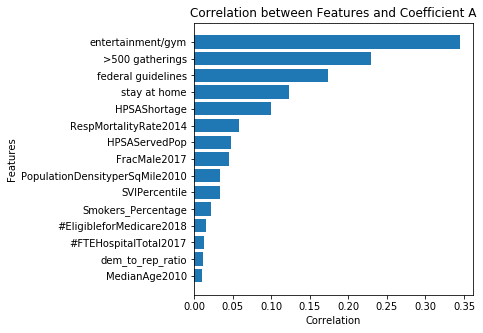

In [19]:
#feature select analysis for coef A
from_A = plot_corr_for('a')

Text(0.5, 1.0, 'Correlation between Features and Number of Confirmed Case')

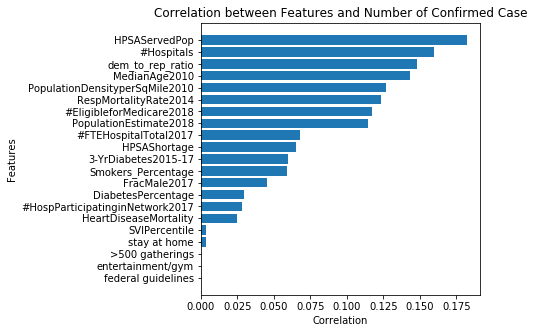

In [20]:
corr = select_df.copy()
corr["Confirm"] = full_table['Confirmed']
corr = corr.corr()
corr = abs(corr)["Confirm"][:-1].sort_values(ascending=True)
plt.figure(figsize=(5,5))
plt.barh(corr.index[:], corr.values[:], align='center')
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.title("Correlation between Features and Number of Confirmed Case" )

In [21]:
# feature analysis by a
X = select_df.copy()
y = abridged_analysis[['a','b','c']].copy()
selector = SelectFromModel(estimator=LinearRegression()).fit(X, y)
result = selector.transform(X)

find_feature1 = []
for i in range(len(result[0])):
    for j in select_df.columns:
        if (list(select_df[j]) == list(result[:,i])):
            find_feature1 += [j]
print("====Best features are====")
print(find_feature1)

====Best features are====
['PopulationEstimate2018', 'PopulationDensityperSqMile2010', '#EligibleforMedicare2018', '3-YrDiabetes2015-17', 'HeartDiseaseMortality', 'Smokers_Percentage', 'stay at home']


In [22]:
# feature analysis by number of confirmed
X = full_table.drop(columns="Confirmed")
y = full_table['Confirmed']

selector = SelectFromModel(estimator=LinearRegression()).fit(X, y)
result = selector.transform(X)

find_feature2 = []
for i in range(len(result[0])):
    for j in X.columns:
        if (list(X[j]) == list(result[:,i])):
            find_feature2 += [j]
print("====Best features are====")
print(find_feature2)

====Best features are====
['FracMale2017', 'HeartDiseaseMortality', 'RespMortalityRate2014']


In [23]:
# find the best score for only using one feature
best_score = 0
best_feature = ""

train, test = train_test_split(select_df_full, test_size=0.2, random_state=42)
X_train = train.drop(columns=['a','b','c'])
Y_train = train[['a']]
X_test = test.drop(columns=['a','b','c'])
Y_test = test[['a']]
    
for feature in select_df.columns:
    feature_test = X_test[[feature]]
    feature_train = X_train[[feature]]
    model = LinearRegression(normalize=True, fit_intercept=True ) 
    model.fit(feature_train, Y_train)
    score = model.score(feature_test, Y_test)
    if score > best_score:
        best_score = score
        best_feature = feature
print("The best score for using one feature :",best_score)
print("The best feature :",best_feature)

The best score for using one feature : 0.09865811116952682
The best feature : entertainment/gym


In [24]:
# function to generate all combination of input list
def combinations(lst):
    return ( set(compress(lst,mask)) for mask in product(*[[0,1]]*len(lst)))

# function to generate all combination of input list of len
def combinations_by_n(lst, length, prev=[]):
    if len(prev) == length:
        return [prev]
    result = []
    for i, val in enumerate(lst):
        to_add = prev.copy()
        to_add.append(val)
        result += combinations_by_n(lst[i+1:], length, to_add)
    return result

# add all distinct element from lst2 into lst
def join_list(lst1, lst2):
    result = lst1[:]
    for i in lst2:
        if i not in lst1:
            result +=[i]
    return result

In [25]:
# select all the feature from previous methods
num_select = 14
combin_feature = join_list(from_A[:num_select], find_feature1)
combin_feature = join_list(combin_feature, find_feature2)
print("Number of select feature for test :", len(combin_feature))
print("Features to test :",combin_feature)

Number of select feature for test : 16
Features to test : ['DiabetesPercentage', '#HospParticipatinginNetwork2017', 'PopulationEstimate2018', '#Hospitals', '3-YrDiabetes2015-17', 'HeartDiseaseMortality', 'MedianAge2010', 'dem_to_rep_ratio', '#FTEHospitalTotal2017', '#EligibleforMedicare2018', 'Smokers_Percentage', 'SVIPercentile', 'PopulationDensityperSqMile2010', 'FracMale2017', 'stay at home', 'RespMortalityRate2014']


PC 1 take : 35.48681877339064 % of data
PC 2 take : 16.535630662870062 % of data
PC 3 take : 14.428274715383058 % of data
PC 4 take : 9.837106241131261 % of data
PC 5 take : 8.543069648043398 % of data
PC 6 take : 3.0785030499576416 % of data
PC 7 take : 2.8017631766140596 % of data
PC 8 take : 2.4895909272932166 % of data
PC 9 take : 1.7706323967992772 % of data
PC 10 take : 1.2596283229545775 % of data
PC 11 take : 0.9134852808425122 % of data
PC 12 take : 0.785543968505551 % of data
PC 13 take : 0.5095748184096668 % of data
It need 13 feature to reach 98.43962198219491 %


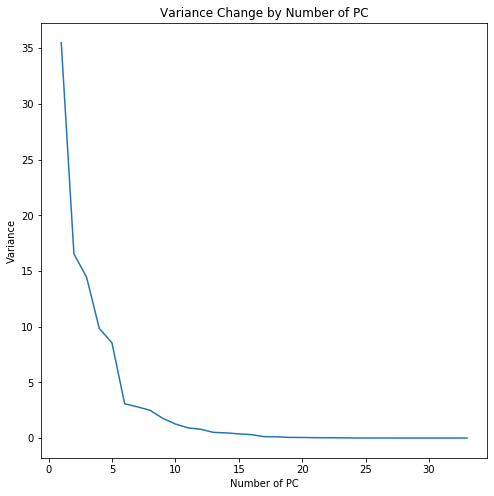

In [26]:
# feature analysis by pca
table_pca = features_in_states.join(abridged_analysis[['a','b','c']])
table_pca = table_pca.drop(columns="States")


train, test = train_test_split(table_pca, test_size=0.2, random_state=53)
X_train = train.drop(columns=['a','b','c'])
Y_train = train[['a']]
X_test = test.drop(columns=['a','b','c'])
Y_test = test[['a']]

# normalize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# do the PCA fit
pca = PCA()
selector = pca.fit_transform(X_train)
result = pca.transform(X_test)

# print the percent of each pc and plot the varican graph
percent = 0
explained_variance = pca.explained_variance_ratio_
for i in range(len(explained_variance)):
    percent = sum(explained_variance[:i])
    if (percent >= 0.98):
        print("It need",i, "feature to reach",percent*100,"%")
        break
    print("PC",i+1,"take :", explained_variance[i] * 100,"% of data")

x = np.arange(1, pca.n_features_ + 1)
y = explained_variance * 100
plt.figure(figsize=(8,8))
plt.plot(x, y)
plt.title('Variance Change by Number of PC')
plt.xlabel('Number of PC')
plt.ylabel('Variance')
plt.show()

In [27]:
# generate all the combination of feature to test
def best_feature_finder():
    all_combination = list(combinations(combin_feature))[1:]

    train, test = train_test_split(select_df_full, test_size=0.2, random_state=42)
    X_train = train.drop(columns=['a','b','c'])
    Y_train = train['a']
    X_test = test.drop(columns=['a','b','c'])
    Y_test = test[['a']]

    best_score = 0
    best_feature1 = []

    for feature in all_combination:
        feature_test = X_test[list(feature)]
        feature_train = X_train[list(feature)]
        model = LinearRegression(normalize=True, fit_intercept=True ) 
        model.fit(feature_train, Y_train)
        score = model.score(feature_test, Y_test)
        if score > best_score:
            best_score = score
            best_feature1 = list(feature)
    print("The best score for using select feature :",best_score)
    print("The best feature :",best_feature1)
    
# this will take a long time, about 10 mins in my Desktop, uncomment it if you want to run
# best_feature_finder()

In [28]:
# calculate the weight and make the predict function by select feature
best_feature = ['3-YrDiabetes2015-17', 'FracMale2017', 'PopulationDensityperSqMile2010', '#FTEHospitalTotal2017', 
                '#EligibleforMedicare2018', 'Smokers_Percentage', 'stay at home', 'SVIPercentile',
                '#HospParticipatinginNetwork2017', 'PopulationEstimate2018']

train, val = train_test_split(select_df_full, test_size=0.2, random_state=42)
X_train = train.drop(columns=['a','b','c'])
Y_train = train['a']
X_test = val.drop(columns=['a','b','c'])
Y_test = val['a']

one_fit_test = X_test[best_feature]
one_feat = X_train[best_feature]
model = LinearRegression(normalize=True, fit_intercept=True ) 
model.fit(one_feat, Y_train)
weight = model.coef_

used_feature = ["States"]
used_feature.extend(best_feature)



def predict(x, state="New York"):
    df = features_in_states[used_feature]
    df.index = features_in_states["States"]
    df = df.drop(columns='States')
    
    new_k_df = coef_df.copy()
    new_k_df.index = new_k_df["States"]
    new_k_df = new_k_df.drop(columns='States')
    
    a = np.array(df.loc[state]) @ weight.T
    de_normalize_factor = a / new_k_df.loc[state][0]
    a /= de_normalize_factor
    
    b = new_k_df.loc[state][1]
    c = new_k_df.loc[state][2]
    
    return int(c/(1+np.exp(-(x-b)/a)))

In [29]:
# function to plot the predict by state
def plot_predict(state= "New York"):
    table = time_series_covid19_confirmed_US.groupby("States").agg("sum")
    x = table.columns
    y = table.loc[state]
    plt.figure(figsize=(8,8))

    plt.xticks(np.arange(0,106,10))
    plt.xticks(rotation=45)
    plt.plot(x, y)
    result = [predict(i, state) for i in range(table.shape[1])]
    plt.plot(x, result)
    plt.xlabel("Day")
    plt.ylabel("Number of Confirm Cases")
    plt.title("Number of Confirm Cases Change by Time in " + state)
    plt.show()
    return result

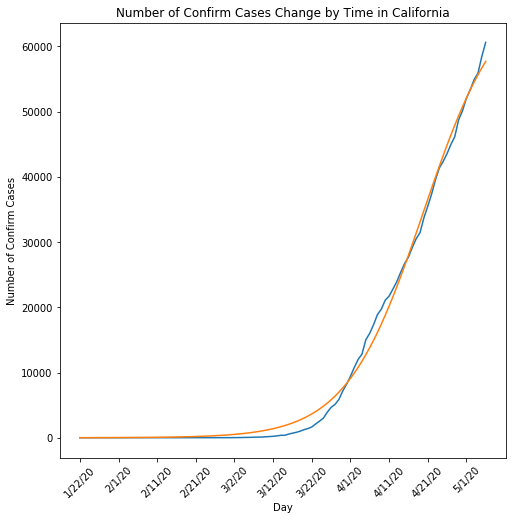

In [30]:
# the prediction for CA
CA_result = plot_predict("California")

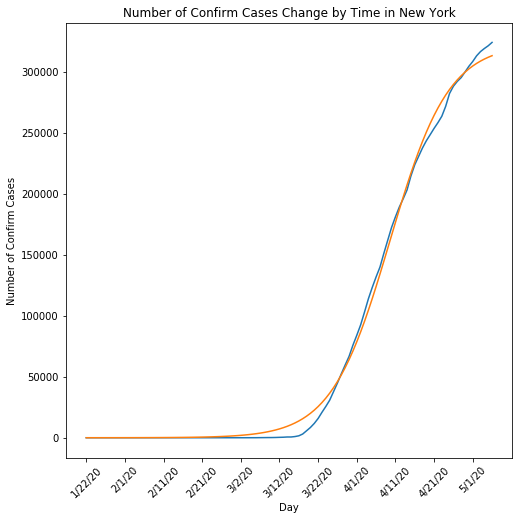

In [31]:
# the prediction for NY
NY_result = plot_predict("New York")

In [32]:
t = time_series_covid19_confirmed_US.groupby("States").agg("sum")
y = t.loc["California"]

training_error = rmse(CA_result, y)
print("California Training RMSE: {}".format(training_error))

y = t.loc["New York"]
training_error = rmse(NY_result, y)
print("New York Training RMSE: {}".format(training_error))

California Training RMSE: 1073.284818623087
New York Training RMSE: 5515.728400896189
